In [1]:
#!/usr/bin/env python
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as colors
import matplotlib.ticker as plticker
from scipy.interpolate import interp1d,  interp2d
from scipy import integrate
from monty.serialization import loadfn, dumpfn

mpl.rcParams.update({'font.size': 16, 'font.family' : 'Helvetica'})
import matplotlib.font_manager as font_manager
font = font_manager.FontProperties(family='Helvetica', # weight='bold',
                                   style='normal', size=16)

def convert_TOF2flux(tof, site_density):
    """ convert catmap production rate to a tof in units of mol/cm2/s
    """
    mol = 6.022140857e+23 
    flux = tof*(site_density/mol)*(1E8)**2 # mol/cm2/s
    return(flux)

def convert_TOF_to_current(tof, site_density=9.61e-5): 
    """ Input a production rate of CO, converts to a current, assuming an input site density
    Assumes catmap production rate, and 
    Assumes signs have already been taken care of (-1 * -1).
    """
    Faraday=96485.33212331001 # C/mol    
    fluxCO2 = convert_TOF2flux(np.array(tof),site_density) * 1e4 # mol/m2 
    j_CO = 2*fluxCO2*Faraday*1e-4*1e3  # mA/cm2
    return j_CO

def map_conc_to_jlim(aCO2):
    """ Provide piecewise linear function for jlim[aCO2]
    Also depends on the potential
    
    Assumes linear section for low [CO2] and quadratic for higher [CO2] activities
    They are pH independent
    """
    fit_seg1 = np.poly1d([0.98305346, 9.42862659])
    fit_seg2 = np.poly1d([-0.21180054,  0.24401647,  8.75401536])
    
    conds = [aCO2 >= 1E-2,  aCO2 < 1E-2]
    funcs = [lambda aCO2: fit_seg2(np.log10(aCO2)),
             lambda aCO2: fit_seg1(np.log10(aCO2)), 
           ]
    return 10**np.piecewise(aCO2, conds, funcs)

def map_conc_to_j1(aCO2,pH):
        """ Provide piecewise linear function for jlim(aCO2)
    Also depends on the potential
    
    Exhibits a log-log relationship with [CO2] vs [pH]
    so get jlim by 10**fit_fn0(np.log10(xv)) where the y-intercept of the fit_fn0 is linearly dependent on pH
    
        """
        b = np.poly1d([-1.14738339, -9.98024684])(pH)     
        fit_fn0 = np.poly1d([1,b])
        return 10**fit_fn0(np.log10(aCO2))

def map_conc_to_j2(aCO2,pH):
        """ Provide piecewise linear function for jlim(aCO2)
    Also depends on the potential
    
    Exhibits a quadratic log-log relationship with [CO2] vs [pH]
    so get jlim by 10**fit_fn1(np.log10(xv)) where the coefficients of the fit_fn1 linearly dependent on pH
    
        """
        a = np.poly1d([-0.00159279,  0.02880045])(pH)
        b = np.poly1d([-0.00134327,  1.11552843])(pH)
        c = np.poly1d([-0.1053373,  -9.97205127])(pH)                   
        fit_fn1 = np.poly1d([a,b,c])
        return 10**fit_fn1(np.log10(aCO2))
    
def BV_fit(x, pH, aCO2): 
    """ This assumes an expression of form
Avg Tafel slope 2 (mV/dec) : -82.21829 +/- 0.61976
Avg Tafel slope 1 (mV/dec) : -38.58085 +/- 0.41449
Avg $U_0$ (V vs SHE, pH corrected)   : -0.14674 +/- 0.00616 *
Avg $U_1$ (V vs SHE, pH uncorrected) : -1.66234 +/- 0.01979 *  
    Returns current in mA/cm2
    """
    # u0 = -0.14 + -0.0591*(pH)
    # u1 = -1.65 # V vs SHE    
    # A2 = 1000/-39 
    # A1 = 1000/-82    
    #u0 = u0rhe + -0.0591*(pH)

    m0 = 39.21646225241602 
    m1 = 82.36927787901362 

    j1 = np.poly1d([-1000./m0, np.log10(map_conc_to_j1(aCO2,pH)) ])
    j2 = np.poly1d([-1000./m1, np.log10(map_conc_to_j2(aCO2,pH))])         
    jlim = np.poly1d([np.log10(map_conc_to_jlim(aCO2))])
    
    fits = [j1,j2,jlim]
    jtot = 1/np.sum([1/10**i(x) for i in fits],axis=0)

    return jtot, j1, j2, jlim

d_labels = {
 'ungapped/shear100/results.json': 'Pe = 10$^7$', #shear 100',
 'ungapped/shear10/results.json' : 'Pe = 10$^6$', #'shear 10',    
 'ungapped/shear1/results.json'  : 'Pe = 10$^5$', #'shear 1',
 'ungapped/shear01/results.json' : 'Pe = 10$^4$', #'shear 01',   
 'gapped/job_1cm_100_defect/results.json': 'defect Pe = 10$^7$', #shear 100',    
 'gapped/job_1cm_10_defect/results.json' : 'defect Pe = 10$^6$', #shear 10',    
 'gapped/job_1cm_1_defect/results.json'  : 'defect Pe = 10$^5$', #shear 1',     
 'gapped/job_1cm_01_defect/results.json' : 'defect Pe = 10$^4$', #shear 01',    

 '1D/BL_300/results_wfrumkin' : '$d_{\\rm BL}$ = 300 $\\mu$m',    
 '1D/BL_300/results_nofrumkin' : '$d_{\\rm BL}$ = 300 $\\mu$m',    

}

# load all processed data
d_refs  = loadfn('final.json')

# set range for interpolation (for final comparisons of % changes in properties
Uv_i = np.linspace(-1.1,-0.4,1001)  # for interpolating the average currents

# Figure 2

/var/folders/nw/f46294cs33d1vdd6nrnyvv_4001bfn/T/ipykernel_23188/3270701046.py:102: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


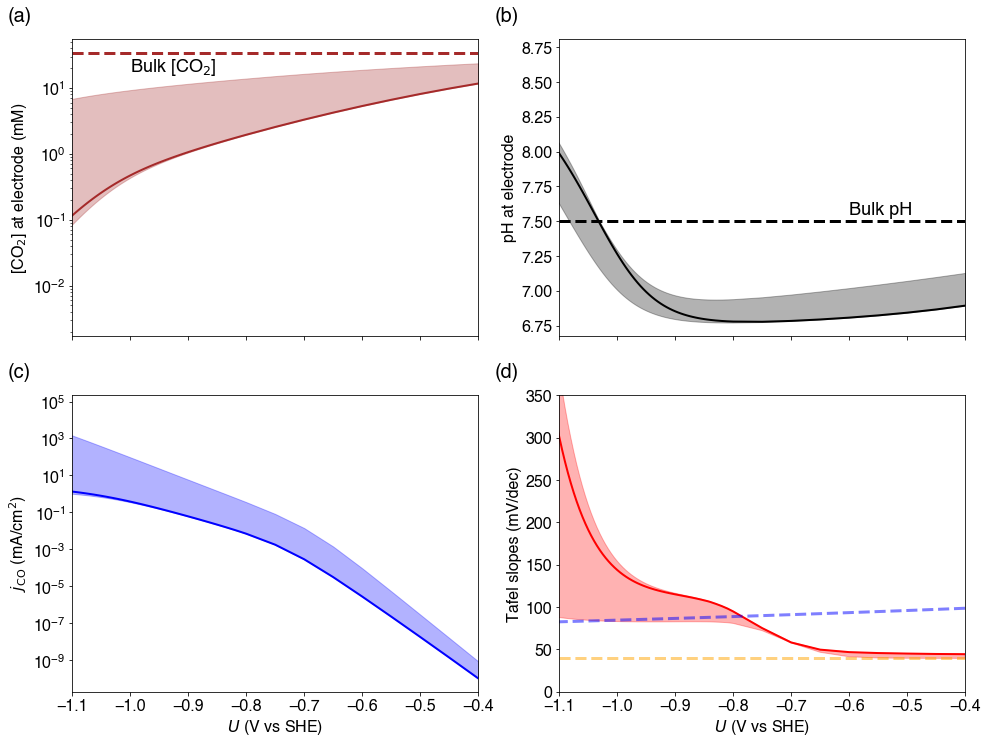

In [2]:
figsize=(16,12)
refkey = 'ungapped/shear1/results.json'

keylist = [
 # 'ungapped/shear01/results.json',      
 'ungapped/shear1/results.json',          
 # 'ungapped/shear10/results.json',
#  'ungapped/shear100/results.json',
]

fig, axs = plt.subplots(nrows=2, ncols=2,figsize=figsize, squeeze=1, sharex='all') # sharey='none', sharex='row', squeeze=0)
for key in keylist:
    
    # [CO2]
    ax = axs[0][0]
    entry='cCO2' ; 
    yscale=34
    Uv     = d_refs[key][entry]['Uv']    
    yv     = d_refs[key][entry]['yv']    
    avgs   = yscale*d_refs[key][entry]['avg']
    min_yx = yscale*np.array([min(i) for i in yv])
    max_yx = yscale*np.array([max(i) for i in yv])

    
    last_color, = ax.plot(Uv, avgs, lw=2, label=d_labels[key],color='brown')    
    ax.fill_between(Uv, min_yx, max_yx, alpha=0.3, color=last_color.get_color())
    ax.axhline(y=34, linewidth=3, linestyle='--', color=last_color.get_color())
    ax.text(-1,18,"Bulk [CO$_2$]",fontsize=18)

    # [pH]
    ax = axs[0][1]
    entry='ph'
    yscale=1
    Uv     = d_refs[key][entry]['Uv']    
    yv     = d_refs[key][entry]['yv']    
    avgs   = yscale*d_refs[key][entry]['avg']
    min_yx = yscale*np.array([min(i) for i in yv])
    max_yx = yscale*np.array([max(i) for i in yv])

    last_color, = ax.plot(Uv, avgs, lw=2, label=d_labels[key],color='k')    
    ax.fill_between(Uv, min_yx, max_yx, alpha=0.3, color=last_color.get_color())
    ax.axhline(y=7.5, linewidth=3, linestyle='--', color=last_color.get_color())
    ax.text(-0.6,7.55,"Bulk pH", fontsize=18)    
    
    # j_CO
    ax = axs[1][0]
    entry='CO_g' 
    yscale=1
    Uv     = d_refs[key][entry]['Uv']    
    yv     = d_refs[key][entry]['yv']    
    avgs   = convert_TOF_to_current(d_refs[key][entry]['avg'])
    min_yx = convert_TOF_to_current(np.array([min(i) for i in yv]))
    max_yx = convert_TOF_to_current(np.array([max(i) for i in yv]))
    
    last_color, = ax.plot(Uv, avgs, lw=2, label=d_labels[key],color='b')      
    ax.fill_between(Uv, min_yx, max_yx, alpha=0.3, color=last_color.get_color())
    

    # Tafels
    ax = axs[1][1]
    entry='Tafels' 
    Uv     = d_refs[key][entry]['Uv']    
    yv     = d_refs[key][entry]['yv']    
    avgs   = d_refs[key][entry]['avg']
    
    max_tafels, min_tafels = [],[]
    for i, U in enumerate(Uv):
        yv0 = [m[i] for m in yv]
        max_tafels.append(max(yv0))
        min_tafels.append(min(yv0))    
    
    last_color, = ax.plot(Uv, avgs, lw=2, label=d_labels[key],color='r')      
    ax.fill_between(Uv, min_tafels, max_tafels, alpha=0.3, color=last_color.get_color())
    
    ax.axhline(y=40, linewidth=3, color='orange', linestyle='--', alpha=0.5)
    tafel_slope_CO2_MKM = [98.63, 97.28, 95.97, 94.7,  93.46, 92.25, 91.07, 89.92, 88.8,  87.71, 86.64, 85.6,
                       84.59, 83.59, 82.62, 81.68, 80.75, 79.85, 78.96, 78.1,77.25]
    U_SHE_MKM =  np.linspace(-0.4,-1.4,21)
    ax.plot(U_SHE_MKM, tafel_slope_CO2_MKM, linewidth=3, linestyle='--', color='b', alpha=0.5)


for ax in axs[1]:
    ax.set_xlabel('$U$ (V vs SHE)')    
    ax.set_xlim([-1.1,-0.4])
    
axs[0][0].set_ylabel('[CO$_2$] at electrode (mM)') ; axs[0][0].set_yscale('log') 
axs[0][1].set_ylabel('pH at electrode' )
axs[1][0].set_ylabel('$j_{\\rm CO}$ (mA/cm$^2$)') ; axs[1][0].set_yscale('log') 
axs[1][1].set_ylabel('Tafel slopes (mV/dec)')  ; axs[1][1].set_ylim([0,350])


tx = -0.16
ty = 1.06
axlabels = ['(a)','(b)']
for i, ax in enumerate(axs[0]):
    ax.text(tx,ty,axlabels[i],fontsize=20,transform=ax.transAxes) 
axlabels = ['(c)','(d)']
for i, ax in enumerate(axs[1]):
    ax.text(tx,ty,axlabels[i],fontsize=20,transform=ax.transAxes) 

fig.savefig('FIG-2.pdf',transparent=0, bbox_inches='tight')     
fig.show()

# Figure 3 (length series)

## [CO2][jCO][pH]

/var/folders/nw/f46294cs33d1vdd6nrnyvv_4001bfn/T/ipykernel_23188/3375079225.py:109: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


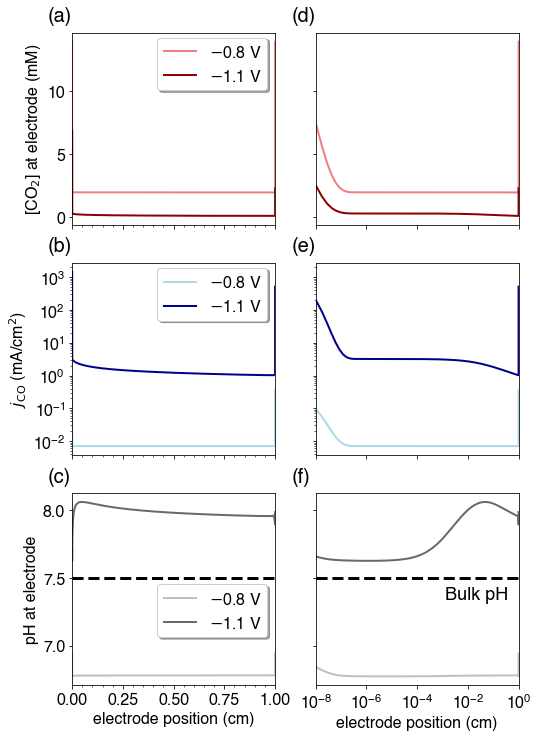

In [3]:
figsize = (8,12)

legargs={'fontsize' : 16, 'fancybox' : 1, 'shadow' : 1, 'loc' : [0.42,0.7]} # 'alignment' : 'left', 'prop' : font} #,  'fonttype' : 'Helvetica'} # 'font.family' : 
c1s = ['lightcoral','darkred']
c2s = ['silver','dimgrey']
c3s = ['lightblue','darkblue']

ivolts = [-100, -44] # indices of particular voltage values

refkey = 'ungapped/shear1/results.json'

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=figsize, squeeze=1,  sharey='row', sharex='col') # sharex='all')sharex='row', squeeze=0)

for i, iU in enumerate(ivolts):
    
    c1 = c1s[i]
    c2 = c2s[i]
    c3 = c3s[i]
    
    # [CO2]
    entry='cCO2' ; 
    yscale=34    
    U = d_refs[refkey][entry]['Uv'][iU]
    
    #plabel=d_labels[refkey]
    plabel='$-$%.1f V' %(np.abs(U))
    
    xv=d_refs[refkey]['xr']*100
    yv=yscale*d_refs[refkey][entry]['yv'][iU]
    
    for ax in [axs[0][0],axs[0][1]]:
        last_color, = ax.plot(xv, yv, lw=2, color=c1, label=plabel)    
        # ax.set_yscale('log') 
    
    # j_CO
    entry='CO_g' 
    xv=d_refs[refkey]['xr']*100
    yv=convert_TOF_to_current(d_refs[refkey][entry]['yv'][iU])
    for ax in [axs[1][0],axs[1][1]]:        
        last_color, = ax.plot(xv, yv, lw=2, color=c3, label=plabel)   
        ax.set_yscale('log')         
    
    # [pH]
    entry='ph'
    xv=d_refs[refkey]['xr']*100
    yv=d_refs[refkey][entry]['yv'][iU]  
    for ax in [axs[2][0],axs[2][1]]:    
        last_color, = ax.plot(xv, yv, lw=2, color=c2, label=plabel)  

axs[0][0].set_ylabel('[CO$_2$] at electrode (mM)') 
axs[2][0].set_ylabel('pH at electrode' )
axs[1][0].set_ylabel('$j_{\\rm CO}$ (mA/cm$^2$)') 
axs[2][0].set_xlabel('electrode position (cm)')
axs[2][1].set_xlabel('electrode position (cm)')

# bulk values and labels
# axs[0][0].axhline(y=34,  linewidth=3, linestyle='--', color='r')
# ax = axs[0][1]
# ax.axhline(y=34,  linewidth=3, linestyle='--', color='r')
# ax.text(0.95,0.85,"Bulk [CO$_2$]",fontsize=18,ha='right',transform=ax.transAxes) 

axs[2][0].axhline(y=7.5, linewidth=3, linestyle='--', color='k')
ax = axs[2][1]
ax.axhline(y=7.5, linewidth=3, linestyle='--', color='k')
ax.text(0.95,0.45,"Bulk pH",fontsize=18,ha='right',transform=ax.transAxes) 

tx = -0.12
ty = 1.06
axlabels = ['(a)','(b)','(c)']
for i, ax in enumerate(axs[:,0]):
    ax.text(tx,ty,axlabels[i],fontsize=20,transform=ax.transAxes) 
tx = -0.12
ty = 1.06
axlabels = ['(d)','(e)','(f)']
for i, ax in enumerate(axs[:,1]):
    ax.text(tx,ty,axlabels[i],fontsize=20,transform=ax.transAxes) 
    
xlim = [0,.01*100]
for ax in axs[:,0]:
    ax.set_xlim(xlim)  
    ax.xaxis.set_minor_locator(plticker.MultipleLocator(base=0.05)) 
    
legargs['loc']=[0.42,0.7]   
axs[0][0].legend(**legargs)
legargs['loc']=[0.42,0.7]  
axs[1][0].legend(**legargs)      
legargs['loc']=[0.42,0.25]
axs[2][0].legend(**legargs)    


xlim = [1E-8,.01*100]    
for ax in axs[:,1]:
    ax.set_xlim(xlim)
    ax.set_xscale('log')
    # min_loc = plticker.LogLocator(subs='all', numticks=10)    
    # ax.xaxis.set_minor_locator(min_loc)  
    maj_loc = plticker.LogLocator(numticks=9)
    ax.xaxis.set_major_locator(maj_loc)    
    # ax.set_xticklabels([1E-8,])    
    
for ax in axs[1,:]:
    maj_loc = plticker.LogLocator(numticks=10)
    ax.yaxis.set_major_locator(maj_loc)    
    min_loc = plticker.LogLocator(subs='all', numticks=10)    
    ax.yaxis.set_minor_locator(min_loc)  


fig.savefig('FIG-3.pdf',transparent=0, bbox_inches='tight')      
fig.show()


## [CO2][jCO][pH] log[co2]

/var/folders/nw/f46294cs33d1vdd6nrnyvv_4001bfn/T/ipykernel_23188/1904565077.py:101: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


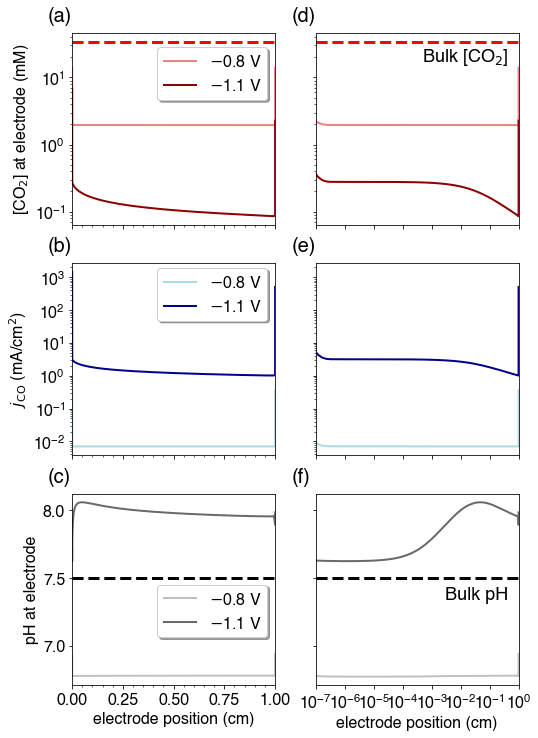

In [4]:
# ivolts = [-100, -44]

refkey = 'ungapped/shear1/results.json'

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=figsize, squeeze=1,  sharey='row', sharex='col') # sharex='all')sharex='row', squeeze=0)
for i, iU in enumerate(ivolts):
    
    c1 = c1s[i]
    c2 = c2s[i]
    c3 = c3s[i]
    
    # [CO2]
    entry='cCO2' ; 
    yscale=34    
    U = d_refs[refkey][entry]['Uv'][iU]
    
    #plabel=d_labels[refkey]
    plabel='$-$%.1f V' %(np.abs(U))
    
    xv=d_refs[refkey]['xr']*100
    yv=yscale*d_refs[refkey][entry]['yv'][iU]
    
    for ax in [axs[0][0],axs[0][1]]:
        last_color, = ax.plot(xv, yv, lw=2, color=c1, label=plabel)    
        ax.set_yscale('log') 
    
    # j_CO
    entry='CO_g' 
    xv=d_refs[refkey]['xr']*100
    yv=convert_TOF_to_current(d_refs[refkey][entry]['yv'][iU])
    for ax in [axs[1][0],axs[1][1]]:        
        last_color, = ax.plot(xv, yv, lw=2, color=c3, label=plabel)   
        ax.set_yscale('log')         
    
    # [pH]
    entry='ph'
    xv=d_refs[refkey]['xr']*100
    yv=d_refs[refkey][entry]['yv'][iU]  
    for ax in [axs[2][0],axs[2][1]]:    
        last_color, = ax.plot(xv, yv, lw=2, color=c2, label=plabel)  

axs[0][0].set_ylabel('[CO$_2$] at electrode (mM)') 
axs[2][0].set_ylabel('pH at electrode' )
axs[1][0].set_ylabel('$j_{\\rm CO}$ (mA/cm$^2$)') 
axs[2][0].set_xlabel('electrode position (cm)')
axs[2][1].set_xlabel('electrode position (cm)')

# bulk values and labels
axs[0][0].axhline(y=34,  linewidth=3, linestyle='--', color='r')
ax = axs[0][1]
ax.axhline(y=34,  linewidth=3, linestyle='--', color='r')
ax.text(0.95,0.85,"Bulk [CO$_2$]",fontsize=18,ha='right',transform=ax.transAxes) 

axs[2][0].axhline(y=7.5, linewidth=3, linestyle='--', color='k')
ax = axs[2][1]
ax.axhline(y=7.5, linewidth=3, linestyle='--', color='k')
ax.text(0.95,0.45,"Bulk pH",fontsize=18,ha='right',transform=ax.transAxes) 

tx = -0.12
ty = 1.06
axlabels = ['(a)','(b)','(c)']
for i, ax in enumerate(axs[:,0]):
    ax.text(tx,ty,axlabels[i],fontsize=20,transform=ax.transAxes) 
tx = -0.12
ty = 1.06
axlabels = ['(d)','(e)','(f)']
for i, ax in enumerate(axs[:,1]):
    ax.text(tx,ty,axlabels[i],fontsize=20,transform=ax.transAxes) 
    
xlim = [0,.01*100]
for ax in axs[:,0]:
    ax.set_xlim(xlim)  
    ax.xaxis.set_minor_locator(plticker.MultipleLocator(base=0.05)) 

legargs['loc']=[0.42,0.65]   
axs[0][0].legend(**legargs)
legargs['loc']=[0.42,0.7]  
axs[1][0].legend(**legargs)      
legargs['loc']=[0.42,0.25]
axs[2][0].legend(**legargs)    


xlim = [1E-9*100,.01*100]    
for ax in axs[:,1]:
    ax.set_xlim(xlim)
    ax.set_xscale('log')
    # min_loc = plticker.LogLocator(subs='all', numticks=10)    
    # ax.xaxis.set_minor_locator(min_loc)  
    maj_loc = plticker.LogLocator(numticks=9)
    ax.xaxis.set_major_locator(maj_loc)    
    # ax.set_xticklabels([1E-8,])    
    
for ax in axs[1,:]:
    maj_loc = plticker.LogLocator(numticks=10)
    ax.yaxis.set_major_locator(maj_loc)    
    min_loc = plticker.LogLocator(subs='all', numticks=10)    
    ax.yaxis.set_minor_locator(min_loc)  


fig.savefig('FIG-3.pdf',transparent=0, bbox_inches='tight')      
fig.show()


# Fig 3 contour (SI)

/var/folders/nw/f46294cs33d1vdd6nrnyvv_4001bfn/T/ipykernel_23188/3351886660.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


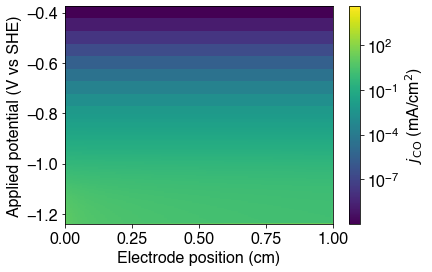

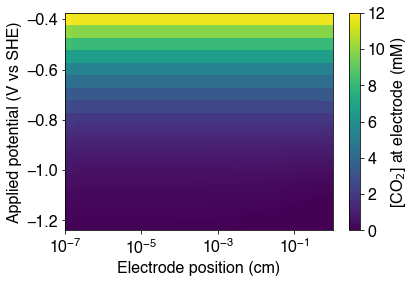

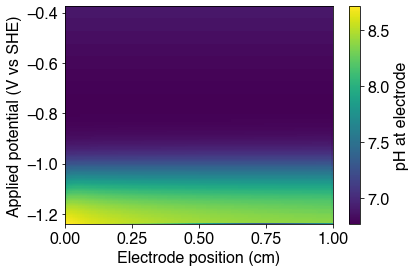

In [5]:

refkey = 'ungapped/shear1/results.json'

xv= d_refs[refkey]['xr']*100

entry = 'cCO2'
U_co2 = d_refs[refkey]['cCO2']['Uv']
Z_co2=34*d_refs[refkey]['cCO2']['yv']

U_ph = d_refs[refkey]['ph']['Uv']
Z_ph = d_refs[refkey]['ph']['yv']

U_j = d_refs[refkey]['ph']['Uv']
Z_j=convert_TOF_to_current(d_refs[refkey]['CO_g']['yv'])

# Uv = U.reverse()

# j_CO
Uv = U_j; Z = Z_j ; plabel = '$j_{\\rm CO}$ (mA/cm$^2$)'
X, Y = np.meshgrid(xv, Uv)
fig = plt.figure() ; ax = fig.add_subplot(111)
cp = ax.pcolor(X, Y, Z,
norm=colors.LogNorm(),
# norm=colors.LogNorm(vmin=1e-06,vmax=1),
cmap='viridis'
)
# ax.set_xlim([1E-7,1]) ; ax.set_xscale('log') ; 
ax.set_ylabel('Applied potential (V vs SHE)')
ax.set_xlabel('Electrode position (cm)')
fig.colorbar(cp,label=plabel)

# [CO2]
Uv = U_co2 ; Z = Z_co2 ; plabel = '[CO$_2$] at electrode (mM)'
X, Y = np.meshgrid(xv, Uv)
fig = plt.figure() ; ax = fig.add_subplot(111)
cp = ax.pcolor(X, Y, Z,
# norm=colors.LogNorm(),
# norm=colors.LogNorm(vmin=1e-01,vmax=15),               
vmin=0, vmax=12,
)
ax.set_xlim([1E-7,1]) ; ax.set_xscale('log') ; 
ax.set_ylabel('Applied potential (V vs SHE)')
ax.set_xlabel('Electrode position (cm)')
fig.colorbar(cp,label=plabel)



# make mesh of cm vs potential
Uv = U_ph ; Z = Z_ph ; plabel = 'pH at electrode'
X, Y = np.meshgrid(xv, Uv)
fig = plt.figure() ; ax = fig.add_subplot(111)
cp = ax.pcolor(X, Y, Z,
)
# ax.set_xlim([1E-7,1]) ; ax.set_xscale('log') ; 
ax.set_ylabel('Applied potential (V vs SHE)')
ax.set_xlabel('Electrode position (cm)')
fig.colorbar(cp,label=plabel)
fig.show()

# Figure 4 

/var/folders/nw/f46294cs33d1vdd6nrnyvv_4001bfn/T/ipykernel_23188/1145798732.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


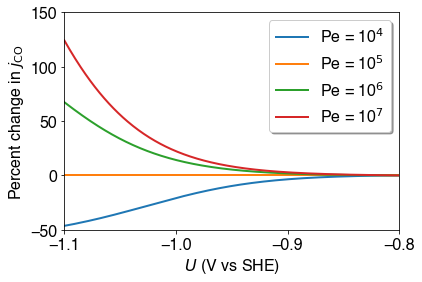

In [6]:
# figsize = (6,4)
legargs={'fontsize' : 16, 'fancybox' : 1, 'shadow' : 1, 'loc' : 'best'} 

refkey = 'ungapped/shear1/results.json'

keylist = [
 'ungapped/shear01/results.json',      
 'ungapped/shear1/results.json',          
 'ungapped/shear10/results.json',
 'ungapped/shear100/results.json',
]

itype = 'cubic'
entry = 'CO_g'
Uv_ref = np.array(d_refs[refkey][entry]['Uv'])
yv_ref = np.array(d_refs[refkey][entry]['avg'])
yvi_ref = interp1d(Uv_ref, yv_ref,itype)
################################################################
fig = plt.figure() ; ax = fig.add_subplot(111)
for key in keylist:
    plabel=d_labels[key]
    Uv = d_refs[key][entry]['Uv']
    yv = np.array(d_refs[key][entry]['avg'])
    yvi= interp1d(Uv, yv,itype)
    ax.plot(Uv_i, 100*(yvi(Uv_i))/(yvi_ref(Uv_i)) - 100, lw=2, label=plabel)
ax.set_xlim([-1.1,-0.8])
ax.set_ylim([-50,150])
ax.set_xlabel('$U$ (V vs SHE)')    
ax.set_ylabel('Percent change in $j_{\\rm CO}$')
ax.legend(**legargs)

fig.savefig('FIG-4.pdf',transparent=0, bbox_inches='tight') 
fig.show()

# Figure 5

Referencing gapped/job_1cm_01_defect/results.json to ungapped/shear01/results.json
Referencing gapped/job_1cm_1_defect/results.json to ungapped/shear1/results.json
Referencing gapped/job_1cm_10_defect/results.json to ungapped/shear10/results.json
Referencing gapped/job_1cm_100_defect/results.json to ungapped/shear100/results.json


/var/folders/nw/f46294cs33d1vdd6nrnyvv_4001bfn/T/ipykernel_23188/2340127857.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


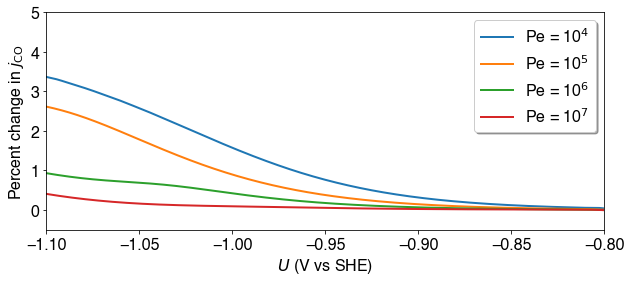

In [7]:

figsize = (10,4)
legargs={'fontsize' : 16, 'fancybox' : 1, 'shadow' : 1, 'loc' : 'best', }

refkey = 'ungapped/shear1/results.json'

refkeylist = [
 'ungapped/shear01/results.json',      
 'ungapped/shear1/results.json',          
 'ungapped/shear10/results.json',
 'ungapped/shear100/results.json',
]

keylist = [
 'gapped/job_1cm_01_defect/results.json',
 'gapped/job_1cm_1_defect/results.json',    
 'gapped/job_1cm_10_defect/results.json',
 'gapped/job_1cm_100_defect/results.json',
]

itype = 'cubic'
entry = 'CO_g'

fig = plt.figure(figsize=figsize) ; ax = fig.add_subplot(111)
for i, key in enumerate(keylist):
    
    refkey = refkeylist[i]
    print("Referencing %s to %s" %(key, refkey))
    
    Uv_ref = np.array(d_refs[refkey][entry]['Uv'])
    yv_ref = np.array(d_refs[refkey][entry]['avg'])
    yvi_ref = interp1d(Uv_ref, yv_ref,itype)
    
    # plabel=d_labels[key]
    plabel=d_labels[refkey]
    
    Uv = d_refs[key][entry]['Uv']
    yv = np.array(d_refs[key][entry]['avg'])
    yvi= interp1d(Uv, yv,itype)
    ax.plot(Uv_i, 100*(yvi(Uv_i))/(yvi_ref(Uv_i)) - 100, lw=2, label=plabel)

ax.set_xlim([-1.1,-0.8])
ax.set_ylim([-0.5,5])
ax.set_xlabel('$U$ (V vs SHE)')    
ax.set_ylabel('Percent change in $j_{\\rm CO}$')
ax.legend(**legargs)

fig.savefig('FIG-5c.pdf',transparent=0, bbox_inches='tight')      
fig.show()

# Figure 6

/var/folders/nw/f46294cs33d1vdd6nrnyvv_4001bfn/T/ipykernel_23188/1043711551.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


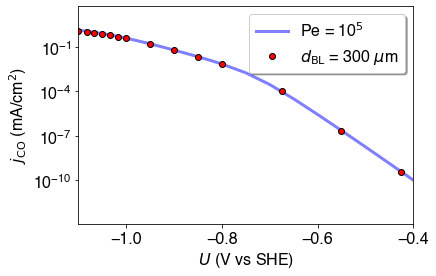

In [8]:
legargs={'fontsize' : 16, 'fancybox' : 1, 'shadow' : 1, 'loc' : 'best' }

keylist = [      
 'ungapped/shear1/results.json',          
 '1D/BL_300/results_wfrumkin',
]

##############################################################################################################################
fig = plt.figure() ; ax = fig.add_subplot(111)
for key in keylist:
    
    # j_CO
    entry='CO_g' 
    yscale=1
    Uv     = d_refs[key][entry]['Uv']    
    yv     = d_refs[key][entry]['yv']    
    avgs   = convert_TOF_to_current(d_refs[key][entry]['avg'])
    
    if '1D' in key:
        last_color, = ax.plot(Uv, avgs, 'ro', markerfacecolor='r', markeredgecolor='k', label=d_labels[key] )      
    else:
        # min_yx = convert_TOF_to_current(np.array([min(i) for i in yv]))
        # max_yx = convert_TOF_to_current(np.array([max(i) for i in yv]))
        last_color, = ax.plot(Uv, avgs, lw=3, label=d_labels[key], color='b', alpha=0.5)   

ax.legend(**legargs)
ax.set_xlabel('$U$ (V vs SHE)')    
ax.set_xlim([-1.1,-0.4])    
ax.set_ylabel('$j_{\\rm CO}$ (mA/cm$^2$)') ; 
ax.set_yscale('log') 
fig.savefig('FIG-6.pdf',transparent=0, bbox_inches='tight') 
fig.show()
##############################################################################################################################


# Figure 7 (1D not including Frumkin)

/var/folders/nw/f46294cs33d1vdd6nrnyvv_4001bfn/T/ipykernel_23188/2768930883.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


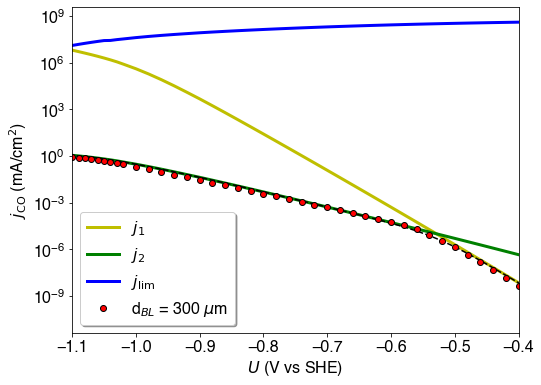

In [13]:
##############################################################################################################################
fig = plt.figure(figsize=(8,6)) ; ax = fig.add_subplot(111)
key = '1D/BL_300/results_nofrumkin'
makeplot=1
if makeplot:
    Uv       = d_refs[key]['Uv']    
    avg_j    = d_refs[key]['jCO']
    avg_pH   = d_refs[key]['ph'] 
    avg_aCO2 = d_refs[key]['cCO2']

    # avg_pH = avg_pH.flatten()    
    # avg_aCO2 = avg_aCO2.flatten()    
    
    # plot 0D BV
    jtot, j1, j2, jlim = [],[],[],[]
    for i, Uval in enumerate(Uv):
        jtotx, j1x, j2x, jlimx = BV_fit(Uval, avg_pH[i], avg_aCO2[i])
        jtot.append(jtotx)
        # polys need to be evaluated at U
        j1.append(10**j1x(Uval))
        j2.append(10**j2x(Uval))
        jlim.append(10**jlimx(Uval))        

    # jtot = [ BV_fit(Uval, avg_pH[i], avg_aCO2[i]) for i, Uval in enumerate(Uv)]
    ax.plot(Uv, j1, label='$j_{1}$' , lw=3, c='y') 
    ax.plot(Uv, j2, label='$j_{2}$' , lw=3, c='g') 
    ax.plot(Uv, jlim, label='$j_{\\rm lim}$' , lw=3, c='b')   
    ax.plot(Uv, jtot, 'k--')        
     # last_color, = ax.plot(Uv, avgs, lw=3, label=d_labels[key], color='b', alpha=0.5)      )    
    
    # ax.plot(U_SHE,j1_all,'y-',lw=2,markersize=2,label='j$_{0,1}$')
    # ax.plot(U_SHE,j2_all,'g-',lw=2,markersize=2,label='j$_{0,2}$')
    # ax.plot(U_SHE,jlim_all,'b-',lw=2,markersize=2,label='j$_{lim}$')    

    # plot 1D:
    last_color, = ax.plot(Uv, avg_j, 'ro', markerfacecolor='r', markeredgecolor='k', label='d$_{BL}$ = 300 $\mu$m')
    # last_color, = ax.plot(U_SHE,j_1d,'bo', markerfacecolor='b', markeredgecolor='k', markersize=4, lw=2, label='w/o Frumkin') # w/o Frumkin
    
legargs['fontsize'] = 16
legargs['loc'] = 'lower left'
legargs['ncol'] = 1
ax.legend(**legargs)
ax.set_xlabel('$U$ (V vs SHE)')    
ax.set_xlim([-1.1,-0.4])    
ax.set_ylabel('$j_{\\rm CO}$ (mA/cm$^2$)') ; 
ax.set_yscale('log')
fig.savefig('FIG-7.pdf',transparent=0, bbox_inches='tight') 
fig.show()

# extra

In [ ]:
keylist = [
 # '1D/BL_64.7/results.json',    
 # '1D/BL_139/results.json',
 '1D/BL_300/results.json',
 # '1D/BL_647/results.json',
]

##############################################################################################################################
fig = plt.figure() ; ax = fig.add_subplot(111)
for key in keylist:
    
    Uv       = d_refs[key]['CO_g']['Uv']    
    avg_j    = convert_TOF_to_current(d_refs[key]['CO_g']['avg'])
    avg_pH   = d_refs[key]['ph']['avg']    
    avg_aCO2 = d_refs[key]['cCO2']['avg']

    avg_pH = avg_pH.flatten()    
    avg_aCO2 = avg_aCO2.flatten()    
    
    # plot 0D BV
    jtot, j1, j2, jlim = [],[],[],[]
    for i, Uval in enumerate(Uv):
        jtotx, j1x, j2x, jlimx = BV_fit(Uval, avg_pH[i], avg_aCO2[i])
        jtot.append(jtotx)
        # polys need to be evaluated at U
        j1.append(10**j1x(Uval))
        j2.append(10**j2x(Uval))
        jlim.append(10**jlimx(Uval))        

    # jtot = [ BV_fit(Uval, avg_pH[i], avg_aCO2[i]) for i, Uval in enumerate(Uv)]
    ax.plot(Uv, j1, label='$j_{1}$' , lw=3) 
    ax.plot(Uv, j2, label='$j_{2}$' , lw=3) 
    ax.plot(Uv, jlim, label='$j_{\\rm lim}$' , lw=3)   
    ax.plot(Uv, jtot, 'k--')        
     # last_color, = ax.plot(Uv, avgs, lw=3, label=d_labels[key], color='b', alpha=0.5)      )    
    
    
    # plot 1D:
    last_color, = ax.plot(Uv, avg_j, 'ro', markerfacecolor='r', markeredgecolor='k', label=d_labels[key] )      
    

ax.legend(**legargs)
ax.set_xlabel('$U$ (V vs SHE)')    
ax.set_xlim([-1.1,-0.4])    
ax.set_ylabel('$j_{\\rm CO}$ (mA/cm$^2$)') ; 
ax.set_yscale('log') 
fig.savefig('FIG-7.pdf',transparent=0, bbox_inches='tight') 
fig.show()

In [ ]:
import pandas as pd

a_CO2_tsv = pd.read_csv('a_CO2_vdiff_CH_17.tsv', sep='\t') 
a_CO2 = []

U_SHE_tsv = pd.read_csv('U_SHE_vdiff_CH_17.tsv', sep='\t')
U_SHE = []

pH_tsv = pd.read_csv('pH_vdiff_CH_17.tsv', sep='\t')
pH = []

j_1d_tsv = pd.read_csv('j_CO_vdiff_CH_17.tsv', sep='\t')
j_1d = []




for i in range(0,len(a_CO2_tsv.values)):
    a_CO2.append(a_CO2_tsv.values[i][0])
    U_SHE.append(U_SHE_tsv.values[i][0])
    pH.append(pH_tsv.values[i][0])
    j_1d.append(j_1d_tsv.values[i][0])
    # v_diff_drop.append(v_diff_drop_tsv.values[i][0])
    
j1_all = []
j2_all = []
jlim_all = []
j_pred = []

# U_SHE = np.linspace(-0.4,-1.2,100)
# print(a_CO2)
for j in range(0,len(U_SHE)):
    # j1,j2,jlim,jtot = BV_fit(U_SHE[j],pH[j],a_CO2[j])
    jtot, j1, j2, jlim = BV_fit(U_SHE[j],pH[j],a_CO2[j])
    j1_all.append(10**j1(U_SHE[j]))
    j2_all.append(10**j2(U_SHE[j]))
    jlim_all.append(10**jlim(U_SHE[j]))
    j_pred.append(jtot)

# v_diff_drop_tsv = pd.read_csv('v_diff_drop_act.tsv', sep='\t')
# v_diff_drop = []
# for i in range(0,len(a_CO2_tsv.values)):
#     v_diff_drop.append(v_diff_drop_tsv.values[i][0])    
# U_actual = []
# for j in range(0,len(a_CO2)):
#      U_actual.append(U_SHE[j] - v_diff_drop[j])
#     j_pred.append(BV_fit(U_SHE[j],pH[j],a_CO2[j]))


# for j in range(0,len(a_CO2)):
# #     for k in range(0,len(U_SHE)):
#     j1,j2,jlim,jtot = BV_fit(U_SHE[j],pH[j],a_CO2[j])
# #     plt.plot(U_SHE[j],10**(jlim(U_SHE[j])),'ro')
# #     plt.plot(U_SHE[j],10**(j2(-0.8)),'go')
        
#         plt.plot(U_SHE[k],10**j2(U_SHE[k]),'ro',markersize=1)
#         plt.plot(U_SHE[k],10**j1(U_SHE[k]),'go',markersize=1)
#         plt.plot(U_SHE[k],10**jlim(U_SHE[k]),'ko',markersize=1)

plt.plot(U_SHE,j1_all,'y-',lw=2,markersize=2,label='j$_{0,1}$')
plt.plot(U_SHE,j2_all,'g-',lw=2,markersize=2,label='j$_{0,2}$')
plt.plot(U_SHE,jlim_all,'b-',lw=2,markersize=2,label='j$_{lim}$')
plt.plot(U_SHE,j_1d,'ro',markersize=3,lw=2,label='d$_{BL}$ = 300 $\mu$m',markeredgecolor='k')

# plt.plot(U_SHE,j_pred,'gx-',markersize=1,lw=1,label='predicted from fit')
# # plt.plot(U_SHE,diff,'gx')

plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.xlim(-1.1,-0.4)
# plt.ylim(0,500)

plt.xlabel(r'$U$  (V vs SHE)')
plt.ylabel('j$_{CO}$ (mA/cm$^2$)')

In [ ]:
##############################################################################################################################
fig = plt.figure() ; ax = fig.add_subplot(111)
for key in keylist:
    
    Uv       = d_refs[key]['CO_g']['Uv']    
    avg_j    = convert_TOF_to_current(d_refs[key]['CO_g']['avg'])
    avg_pH   = d_refs[key]['ph']['avg']    
    avg_aCO2 = d_refs[key]['cCO2']['avg']

    avg_pH = avg_pH.flatten()    
    avg_aCO2 = avg_aCO2.flatten()    
    
    # plot 0D BV
    jtot, j1, j2, jlim = [],[],[],[]
    for i, Uval in enumerate(Uv):
        jtotx, j1x, j2x, jlimx = BV_fit(Uval, avg_pH[i], avg_aCO2[i])
        jtot.append(jtotx)
        # polys need to be evaluated at U
        j1.append(10**j1x(Uval))
        j2.append(10**j2x(Uval))
        jlim.append(10**jlimx(Uval))        

    # jtot = [ BV_fit(Uval, avg_pH[i], avg_aCO2[i]) for i, Uval in enumerate(Uv)]
    ax.plot(Uv, j1, label='$j_{1}$' , lw=3) 
    ax.plot(Uv, j2, label='$j_{2}$' , lw=3) 
    ax.plot(Uv, jlim, label='$j_{\\rm lim}$' , lw=3)   
    ax.plot(Uv, jtot, 'k--')        
     # last_color, = ax.plot(Uv, avgs, lw=3, label=d_labels[key], color='b', alpha=0.5)      )    
    
    ax.plot(U_SHE,j1_all,'y-',lw=2,markersize=2,label='j$_{0,1}$')
    ax.plot(U_SHE,j2_all,'g-',lw=2,markersize=2,label='j$_{0,2}$')
    ax.plot(U_SHE,jlim_all,'b-',lw=2,markersize=2,label='j$_{lim}$')    

    # plot 1D:
    last_color, = ax.plot(Uv, avg_j, 'ro', markerfacecolor='r', markeredgecolor='k', label=d_labels[key] )    # w/ Frumkin  
    last_color, = ax.plot(U_SHE,j_1d,'bo', markerfacecolor='b', markeredgecolor='k', markersize=4, lw=2, label='w/o Frumkin') # w/o Frumkin
    
legargs['fontsize'] = 12
legargs['loc'] = 'lower left'
legargs['ncol'] = 3
ax.legend(**legargs)
ax.set_xlabel('$U$ (V vs SHE)')    
ax.set_xlim([-1.1,-0.4])    
ax.set_ylabel('$j_{\\rm CO}$ (mA/cm$^2$)') ; 
ax.set_yscale('log')
# ax.set_ylim([1E-2,2E1])
fig.savefig('FIG-7.pdf',transparent=0, bbox_inches='tight') 
fig.show()